# PSF Experiment 2.0

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf

#...vs them!
import ngmix
import galsim
from multiprocessing import Pool

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [3]:
g_psf =  array([0.02,0.01],dtype='float32')
rng = np.random.RandomState(31415)
shear_true = array([0.01,0.0],dtype='float32')
stamp_size = 51
batch_size = 1000
noise_level = 1e-4
shape_noise = 0
psf_noise_level = noise_level/1000
scale = 0.263
ncpus = 24

## Get to the Data!

In [4]:
data= tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

## Create observations for ngmix

In [6]:
def observer(batch,shear_true):
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_img = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_img
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + 0/scale, col=cen[1] + 0/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return obslist  

In [7]:
obslist = observer(onebatch,shear_true)

## Make the ngmix runner

In [8]:
def ngmix_booter(rng,**kwargs):
  options = {
    'T_range' : [-1.0, 10.],
    'F_range' : [-1.0, 10.],
    'psf_ngauss': 1,
    'ntry' : 2,
    'psf': 'dilate',
    'types': ['noshear', 
              '1p', '1m', '2p', '2m', '1p_psf', '1m_psf', '2p_psf', '2m_psf'
              ],
    'scale': 0.263,
        
  }

  g_prior = ngmix.priors.GPriorBA(sigma=0.1, rng=rng)
  cen_prior = ngmix.priors.CenPrior(
      cen1=0, cen2=0, sigma1=options['scale'], sigma2=options['scale'], rng=rng,
  )
  T_prior = ngmix.priors.FlatPrior(minval=options['T_range'][0], maxval=options['T_range'][1], rng=rng)
  F_prior = ngmix.priors.FlatPrior(minval=options['F_range'][0], maxval=options['F_range'][1], rng=rng)

  prior = ngmix.joint_prior.PriorSimpleSep(
      cen_prior=cen_prior,
      g_prior=g_prior,
      T_prior=T_prior,
      F_prior=F_prior,
  )
  # fit the object to an exponential disk

  fitter = ngmix.fitting.Fitter(model='exp', prior=prior)
  # make parameter guesses based on a psf flux and a rough T
  guesser = ngmix.guessers.TPSFFluxAndPriorGuesser(
      rng=rng,
      T=0.25,
      prior=prior,
  )

  # psf fitting with coelliptical gaussians
  psf_ngauss = 1
  psf_fitter = ngmix.fitting.CoellipFitter(ngauss=psf_ngauss)
  # special guesser for coelliptical gaussians
  psf_guesser = ngmix.guessers.CoellipPSFGuesser(rng=rng, ngauss=psf_ngauss)

  # this runs the fitter. We set ntry=2 to retry the fit if it fails
  psf_runner = ngmix.runners.PSFRunner(
      fitter=psf_fitter, guesser=psf_guesser,
      ntry=2,
  )
  runner = ngmix.runners.Runner(
      fitter=fitter, guesser=guesser,
      ntry=2,
  )

  # this "bootstrapper" runs the metacal image shearing as well as both psf
  # and object measurements
  #
  # We will just do R11 for simplicity and to speed up this example;
  # typically the off diagonal terms are negligible, and R11 and R22 are
  # usually consistent

  boot = ngmix.metacal.MetacalBootstrapper(
      runner=runner,
      psf_runner=psf_runner,
      rng=rng,
      psf=options['psf'],
      types=options['types'],
  )
  return boot

boot = ngmix_booter(rng)

...and run it:

In [ ]:
def step(obs):
  resdict, _ = boot.go(obs)
  return resdict

print(f"Parallel running fitters in  processes...")
pool = Pool(ncpus)
dlist = pool.map(step,obslist)
pool.close()
print("Done!")

## Extract the results

In [ ]:
def get_metacal_response_ngmix(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
  g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
  g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
  g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [ ]:
def metacal_shear(e,R):
  return linalg.inv(R) @ e

def metacal_shear_psf(e,R,ep, Rp):
  return linalg.inv(R) @ (e - Rp @ ep)

def bootstraper(x,nboot):
  resample = random.randint(0,len(x),[nboot,len(x)])
  return x[resample].mean(axis=0)
  
def evaluator(ellips, R, g_psf, Rpsf):
  nboot=1000 #bootstraps make it look professional

  #uncorrected  
  resample = random.randint(0,batch_size,[nboot,batch_size])
  e = bootstraper(ellips,nboot).reshape(-1,2,1)
  R = bootstraper(R,nboot)
  Rp = bootstraper(Rpsf,nboot)

  shears = metacal_shear(e,R)
  shear = shears.mean(axis=0)
  shear_err = shears.std(axis=0)


  shearcorrs = metacal_shear_psf(e,R,g_psf.reshape(-1,2,1), Rp)
  shearcorr = shearcorrs.mean(axis=0)
  shearcorr_err = shearcorrs.std(axis=0)
  return shear[...,0], shear_err[...,0],  shearcorr[...,0], shearcorr_err[...,0]

In [ ]:
results = [get_metacal_response_ngmix(resdict) for resdict in dlist]
ellips = array([result[0]['noshear'] for result in results])
R = array([result[1] for result in results])
Rpsf = array([result[2] for result in results])

In [ ]:
shear, shear_err, shearcorr, shearcorr_err= evaluator(ellips, R,g_psf, Rpsf)
print('ngmix')
print('-------------------------------------------------')
print('With psf correction:')
print(f"shear: {shearcorr[0]:.5f} +/- {shearcorr_err[0]*3:.6f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"shear: {shear[0]:.5f} +/- {shear_err[0]*3:.6f} (99.7%% conf)")

## AutoMetaCal

We will run with a simple moments-based method for now.

In [ ]:
###new functions
import galflow as gf
def generate_mcal_image(gal_images,
                        psf_images,
                        reconvolution_psf_image,
                        g, gp,
                        padfactor=3):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)  
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)  
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  
  #Get batch info
  batch_size, nx, ny = gal_images.get_shape().as_list()  
      
  #add pads in real space
  fact = (padfactor - 1)//2 #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
    
  padded_gal_images = tf.pad(gal_images,paddings)
  padded_psf_images = tf.pad(psf_images,paddings)
  padded_reconvolution_psf_image = tf.pad(reconvolution_psf_image,paddings)
    
  #Convert galaxy images to k space
  im_shift = tf.signal.ifftshift(padded_gal_images,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, tf.complex64)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  
  #Convert psf images to k space  
  psf_complex = tf.cast(padded_psf_images, tf.complex64)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,tf.complex64)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  #Convert reconvolution psf image to k space 
  rpsf_complex = tf.cast(padded_reconvolution_psf_image, tf.complex64)
  rpsf_fft =  tf.signal.fft2d(rpsf_complex)
  rpsf_fft_abs = tf.abs(rpsf_fft)
  psf_fft_abs_complex = tf.cast(rpsf_fft_abs,tf.complex64)
  krpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])

  # Compute Fourier mask for high frequencies
  # careful, this is not exactly the correct formula for fftfreq
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,padfactor*nx),
                       tf.linspace(-0.5,0.5,padfactor*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)
  
  # Deconvolve image from input PSF
  im_deconv = imk * ( (1./(kpsf+1e-10))*mask)

  # Apply shear to the  deconv image
  im_sheared = gf.shear(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]  

  # Apply shear to the  kpsf image
  kpsf_sheared = gf.shear(tf.expand_dims(krpsf,-1), gp[...,0], gp[...,1])[...,0]    
  
  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * kpsf_sheared * mask))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  return img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]

def get_metacal_response(gal_images,
                         psf_images,
                         reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])
  epsf = method(reconvolution_psf_image)
  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   psf_images,
                                   gs[:,0:2],gs[:,2:4]))
    
  # Compute response matrix

  Rs = tape.batch_jacobian(e, gs)
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

In [ ]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=0.2, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,psf_images,method)

In [28]:
def observer_amc(batch,shear_true):
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_img = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_img
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  
  return gal_images, psf_images  

In [19]:
gal_images, psf_images  = observer_amc(onebatch,shear_true)
e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images)

In [21]:
shear, shear_err, shearcorr, shearcorr_err= evaluator(e_amc.numpy(), R_auto.numpy() ,e_psf.numpy(), R_psf.numpy())

In [22]:
print('AutoMetaCal')
print('-------------------------------------------------')
print('With psf correction:')
print(f"shear: {shearcorr[0]:.5f} +/- {shearcorr_err[0]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"shear: {shear[0]:.5f} +/- {shear_err[0]*3:.8f} (99.7%% conf)")

AutoMetaCal
-------------------------------------------------
With psf correction:
shear: 0.00490 +/- 0.00017333 (99.7%% conf)
-------------------------------------------------
Without psf correction:
shear: 0.02764 +/- 0.00017375 (99.7%% conf)


## A few batches!

In [28]:
shear_range = linspace(-.1,.1,10)
verbose = False
shear_ngmix_list = []
shear_err_ngmix_list = []
shearcorr_ngmix_list = []
shearcorr_err_ngmix_list = []

shear_amc_list = []
shear_err_amc_list = []
shearcorr_amc_list = []
shearcorr_err_amc_list = []
import tqdm
for shear in tqdm.tqdm(shear_range):
  shear_true = array([shear,0.],dtype='float32')  
  
  #ngmix
  obslist = observer(onebatch,shear_true)

  #print(f"Parallel running ngmix in {ncpus}  processes...")
  pool = Pool(ncpus)
  dlist = pool.map(step,obslist)
  pool.close()
  #print("Done!")  
  
  results = [get_metacal_response_ngmix(resdict) for resdict in dlist]
  
  ellips = array([result[0]['noshear'] for result in results])
  R = array([result[1] for result in results])
  Rpsf = array([result[2] for result in results])
  
  shear_ngmix, shear_err_ngmix, shearcorr_ngmix, shearcorr_err_ngmix= evaluator(ellips, 
                                                                                R,
                                                                                g_psf, 
                                                                                Rpsf)
 
  #AutoMetaCal
  gal_images, psf_images  = observer_amc(onebatch,shear_true)
  e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images)
  shear_amc, shear_err_amc, shearcorr_amc, shearcorr_err_amc= evaluator(e_amc.numpy(), 
                                                                        R_auto.numpy() ,
                                                                        e_psf.numpy(), 
                                                                        R_psf.numpy())
  
  #gather results
  shear_ngmix_list += [shear_ngmix]
  shear_err_ngmix_list += [shear_err_ngmix]
  shearcorr_ngmix_list += [shearcorr_ngmix]
  shearcorr_err_ngmix_list += [shearcorr_err_ngmix]

  shear_amc_list += [shear_amc]
  shear_err_amc_list += [shear_err_amc]
  shearcorr_amc_list += [shearcorr_amc]
  shearcorr_err_amc_list += [shearcorr_err_amc]
  
  #print results
  if verbose:
    print(f"Testing shear true: g1 = {shear_true[0]}, g2 = {shear_true[0]}")
    print('ngmix')
    print('-------------------------------------------------')
    print('With psf correction:')
    print(f"g1: {shearcorr_ngmix[0]:.5f} +/- {shearcorr_err_ngmix[0]*3:.2f} (99.7%% conf)")
    print(f"g2: {shearcorr_ngmix[1]:.5f} +/- {shearcorr_err_ngmix[0]*3:.2f} (99.7%% conf)")
    print('-------------------------------------------------')
    print('Without psf correction:')
    print(f"g1: {shear_ngmix[0]:.5f} +/- {shear_err_ngmix[0]*3:.2f} (99.7%% conf)")
    print(f"g2: {shear_ngmix[1]:.5f} +/- {shear_err_ngmix[0]*3:.2f} (99.7%% conf)")
    print()
    print('AutoMetaCal')
    print('-------------------------------------------------')
    print('With psf correction:')
    print(f"g1: {shearcorr_amc[0]:.5f} +/- {shearcorr_err_amc[0]*3:.8f} (99.7%% conf)")
    print(f"g2: {shearcorr_amc[1]:.5f} +/- {shearcorr_err_amc[0]*3:.8f} (99.7%% conf)")
    print('-------------------------------------------------')
    print('Without psf correction:')
    print(f"g1: {shear_amc[0]:.5f} +/- {shear_err_amc[0]*3:.8f} (99.7%% conf)")
    print(f"g2: {shear_amc[1]:.5f} +/- {shear_err_amc[0]*3:.8f} (99.7%% conf)")

100%|██████████| 10/10 [08:13<00:00, 49.39s/it]


In [1]:
Rpsf

NameError: name 'Rpsf' is not defined

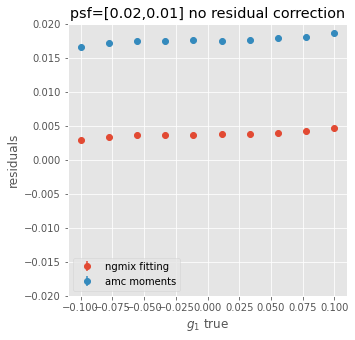

In [29]:
style.use('ggplot')
figure(figsize=(5,5))
X1 = shear_range
Y1 =  array(shear_ngmix_list)[:,0] - X1
Y1err = array(shear_err_ngmix_list)[:,0]
errorbar(X1,Y1,Y1err*3,fmt='o',label= 'ngmix fitting')
Y1 =  array(shear_amc_list)[:,0] - X1
Y1err = array(shear_err_ngmix_list)[:,0]
errorbar(X1,Y1,Y1err*3,fmt='o',label= 'amc moments')
xlabel('$g_1$ true')
ylabel('residuals')
xlim([-.11,.11])
ylim([-.02,.02])
legend()
title('psf=[0.02,0.01] no residual correction')
savefig('psf_experiment0b.jpg',bbox_inches='tight')

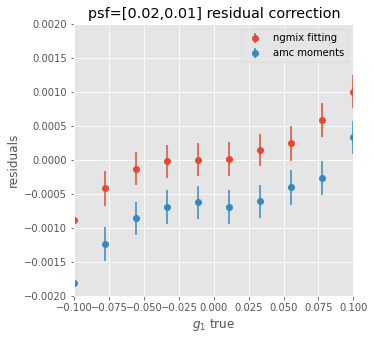

In [31]:
style.use('ggplot')
figure(figsize=(5,5))
X1 = shear_range
Y1 =  array(shearcorr_ngmix_list)[:,0] - X1
Y1err = array(shearcorr_err_ngmix_list)[:,0]

errorbar(X1,Y1,Y1err*3,fmt='o',label= 'ngmix fitting')


Y1 =  array(shearcorr_amc_list)[:,0] - X1
Y1err = array(shearcorr_err_ngmix_list)[:,0]

errorbar(X1,Y1,Y1err*3,fmt='o',label= 'amc moments')

xlabel('$g_1$ true')
ylabel('residuals')
xlim([-.1,.1])
ylim([-.002,.002])
legend()
title('psf=[0.02,0.01] residual correction')
savefig('psf_experiment1b.jpg',bbox_inches='tight')

## Old Code